# Predict Oil Palm Plantation from Satellite Images

Train a model that takes as input a satellite image and outputs a prediction of how likely it is that the image contains an oil palm plantation. The model is used to make prediction on the unlabeled images in test set. This is a [WiDS Datathon 2019](https://www.kaggle.com/c/widsdatathon2019) in Kaggle. 

The training set images are stored in folder `train_images` and the test images are stored in folder `leaderboard_test_data`, and `leaderboard_holdout_data`. The label is in the file `traininglabels.csv` with label 1 means the image has oil palm. 

* Libraries: fastai, pytorch libraries, opencv
* Hardwares: Nvidia GTX1060 3 GB
* Split image into train, validation and test sets
* Workwith Imbalance class: only 6% of the images belong to a second class (with oilpalm). Solve by create an augmented images from the training set. Details in this [notebook](https://github.com/worasom/WiDS_Datathon_2019/blob/master/generate_augmented_images.ipynb)
*	Transfer learning using pretrained models  
* Explore different CNN architectures: resnet34, resnext201, dn201 in this [notebook](https://github.com/worasom/WiDS_Datathon_2019/blob/master/oil_palm_images-arch_survey.ipynb)
* Submit different prediction to kaggle to verify correlation between the hold out set and the internal test/validation sets this [notebook](https://github.com/worasom/WiDS_Datathon_2019/blob/master/oil_palm_images-arch_survey.ipynb).
* Pretrained neural network using previous Kaggle competition in this[notebook](https://github.com/worasom/WiDS_Datathon_2019/blob/master/pretrain_planet.ipynb) and use the trained weight for this problem in this [notebook](https://github.com/worasom/WiDS_Datathon_2019/blob/master/oil_palm_images-trans.ipynb).
*	Achieve 95% accuracy for the Kaggle hold out dataset (151 on the leaderboard) 

I learn a lot from working on this project. First, creating augmented images is the key to work with imbalance dataset. Second, it looks like deep network perform better on this dataset, but once picking a deep NN, it does not matter if it's resnext101 or restnet152 or dn201. Third, I learned how to transfer learning weights from other images to this set. Although the accuracy was not better, but it was a very good experience. 

In [1]:
#setup the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.greedy=True

import sys
import feather
from pathlib import Path
from glob import glob
sys.path.append(r'C:\Users\Benny\fastai\old')

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

In [4]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is FC06-B52C

 Directory of C:\Users\Benny\Documents\Fern\widsdatathon2019

02/27/2019  10:28 AM    <DIR>          .
02/27/2019  10:28 AM    <DIR>          ..
02/27/2019  10:19 AM    <DIR>          .ipynb_checkpoints
02/20/2019  09:27 PM        46,258,105 leaderboard_holdout_data.zip
02/27/2019  10:24 AM    <DIR>          leaderboard_test_data
02/20/2019  09:27 PM        94,811,591 leaderboard_test_data.zip
02/27/2019  10:28 AM             1,933 oil_palm_images.ipynb
02/20/2019  09:27 PM           137,236 SampleSubmission.csv
02/20/2019  09:27 PM           362,925 traininglabels.csv
02/25/2019  01:01 PM    <DIR>          train_images
               5 File(s)    141,571,790 bytes
               5 Dir(s)  23,443,681,280 bytes free


## Exploratory Data Analysis

In [6]:
trn_path = 'train_images/'
filenames = glob(trn_path+'*.jpg')
len(filenames)

15244

In [3]:
trn_df = pd.read_csv('traininglabels.csv') 
trn_df.columns

Index(['image_id', 'has_oilpalm', 'score'], dtype='object')

In [15]:
trn_df_mod = trn_df.drop('score', axis=1)
trn_df_mod['image_id'] = trn_path + trn_df['image_id'].values

In [17]:
trn_df_mod.to_csv('trainlabels_mod.csv',index=False)

In [13]:
trn_df_mod = pd.read_csv('trainlabels_mod.csv')

In [20]:
trn_df_mod.head(), len(trn_df_mod)

(                         image_id  has_oilpalm
 0  train_images/img_000002017.jpg            0
 1  train_images/img_000012017.jpg            0
 2  train_images/img_000022017.jpg            0
 3  train_images/img_000072017.jpg            0
 4  train_images/img_000082017.jpg            0, 15244)

In [21]:
filenames = trn_df_mod['image_id'].values

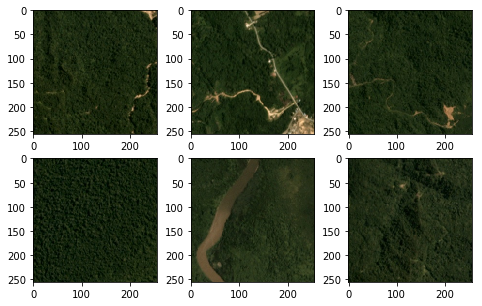

In [48]:
plt.figure(figsize=(8,5))

for i in range(1,7):
    ax = plt.subplot(2,3,i)
    ax = plt.imshow(plt.imread(filenames[i]))   

In [54]:
trn_df_mod.has_oilpalm.value_counts()

0    14302
1      942
Name: has_oilpalm, dtype: int64

Very unbalance dataset 

In [55]:
img = plt.imread(filenames[0])
img.shape

(256, 256, 3)

In [4]:
#allodate some data into a test set 
test_idxs = get_cv_idxs(len(trn_df), val_pct=0.1, seed=52)
test = trn_df.iloc[test_idxs]
y_test = test['has_oilpalm'].values

len(y_test)

1524

In [182]:
#put internal test images into a test folder 
import shutil

t_filenames = test['image_id'].values
for file in t_filenames:
    shutil.copy(trn_path+file,'test/'+file) 

In [73]:
df = trn_df_mod.drop(test_idxs , axis=0)
df['has_oilpalm'].value_counts()

0    12880
1      840
Name: has_oilpalm, dtype: int64

In [74]:
len(df)
df.to_csv('train_val.csv',index=False)

In [100]:
# get baseline accuracy 
from sklearn.metrics import accuracy_score, log_loss

In [102]:
y_true = trn_df_mod['has_oilpalm'].values
y_pred = np.zeros(len(y_true))
print('baseline accuracy =', accuracy_score(y_true, y_pred))
print('baseline loss =', log_loss(y_true, y_pred))

baseline accuracy = 0.9382051954867489
baseline loss = 2.1343169354503986


In summary, we have 15244 training images, and will allocate 1524(10%) as a test and as 2744 validation(20% of the remaining), leaving 10976 for the training set. There are two hold out sets: leader_board_test folder has 4356 files and learder_board_holdout_data has 2178 files. The internal test images are copied to folder test, and the train image list is in the 'train_val.csv'.

About 6% of the images have oil palm. The training set should have about 658 images with oil palm. The images are 256 x 256 pixels and have 3 channels. Baseline: if a model predicts all images to have no oil palm will get 94% accuracy and 2 log_loss. Public leader board is 99.957%.

Leaderboard test images are in the same folder as the internal test images. 

## Unbalance Training Data

This dataset has unbalance dataset, only 6% of images have oil palm. To solve this, I will add augmented images this class in the training folder. 

1. Define functions to generate augmented images: 

    * `rotate_cv` return a rotated image. I use this to create 7 more images each with multiple of 45 deg rotation.
    * `stretch_cv` return 3 images with a 1.01 horizontal or vertical zoom or both.  
    * I will get (7+3) x 672 = 6720 images
    * Randomly select half of these images to put into either `lighting` or `blur`. This procedure should give me 
    * At the end, I will have ((7+3) x 672 + 3360 about 10080 images or more (if perform randomness two times will generate more images)
  
2. Randomly shuffle the images and include 8000 images into a training label csv file with these filenames and label 1. Note that the images are in a separate folder)

This is done in another [notebook](https://github.com/worasom/WiDS_Datathon_2019/blob/master/generate_augmented_images.ipynb)

## Try different architectures

Need to verify if the internal test set is similar to the kaggle test set. If they are similar the accuracy scores for the internal test set should be the same. This is done by submitting results from 3 - 5 models and plot the internal accuracy vs submitted accuracy.


In [5]:
df = pd.read_csv('train_val.csv')

In [6]:
#split into train and validation set
idxs = get_cv_idxs(len(df), val_pct=0.2, seed=52)
len(df), len(idxs), len(df) - len(idxs), len(y_test)

(13720, 2744, 10976, 1524)

In [89]:
# see how data is distributed
print(df.loc[idxs]['has_oilpalm'].value_counts(), 
      df.loc[~df.index.isin(idxs)]['has_oilpalm'].value_counts())

0    2576
1     168
Name: has_oilpalm, dtype: int64 0    10304
1      672
Name: has_oilpalm, dtype: int64


### Pick an architecture 

Pick a learning rate, and image transformation

In [7]:
# test the accucary of the internal test set 
#and generate prediction on kaggle test set
def separate_test_set(data, log_preds):
    '''separate prediction for test images from the submission test images
    return log_preds_test and log_preds_sub
    '''
    submitfile = pd.read_csv('SampleSubmission.csv')
    submit_fnames = submitfile['image_id'].values
    fnames = data.test_dl.dataset.fnames
    fnames = [name.split('\\')[1] for name in fnames]
    fnames = np.array(fnames)
    
    log_preds_test = log_preds[~np.in1d(fnames, submit_fnames)]
    log_preds_sub = log_preds[np.in1d(fnames, submit_fnames)]
    submit_fnames = fnames[np.in1d(fnames, submit_fnames)]
    return log_preds_test, log_preds_sub, submit_fnames

In [16]:
arch = dn201
sz = 128
bs = 5 # small batch size for home

In [ ]:
# try custom augmentation did not give good result.
aug_tfms = [RandomRotate(45, p=0.75, mode=cv2.BORDER_REFLECT), 
            RandomRotateZoom(deg=180, zoom=1.1, stretch=0.5), 
            RandomDihedral(), RandomFlip(), RandomLighting(0.05,0.05),
            Cutout(n_holes=5, length=20),
            AddPadding(pad=20, mode=cv2.BORDER_WRAP)]           

In [17]:
aug_tfms = transforms_top_down

In [18]:
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_csv('', '', 'train_val_augment.csv', bs=bs, tfms=tfms, val_idxs=idxs,
                                    test_name='test', continuous=False, skip_header=True, num_workers=8, cat_separator=',')

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
#learning rate finder
lrf=learn.lr_find()
learn.sched.plot()

In [12]:
lr = 1e-4 
learn.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.130057   0.089711   0.971939  



[0.08971147775736911, 0.971938769254323]

In [13]:
learn.precompute = False
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.131334   0.037259   0.991983  
    1      0.147549   0.039333   0.990525                                                                              
    2      0.13048    0.040784   0.989796                                                                              



[0.040783694520512594, 0.9897959159345043]

In [14]:
learn.unfreeze()
lrs = np.array([lr/9, lr/3, lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.176688   0.038795   0.987974  
    1      0.16357    0.032795   0.988338                                                                              
    2      0.14059    0.039038   0.986516                                                                              
    3      0.138838   0.032242   0.988338                                                                              
    4      0.087932   0.029306   0.991983                                                                              
    5      0.103551   0.027675   0.992711                                                                              
    6      0.098274   0.033771   0.990889                                                                              



[0.033771021880054, 0.9908892108730255]

In [15]:
# accuracy on the validation set and internal test set with TTA
log_preds, _ = learn.TTA()
val_accuracy = accuracy_np(np.mean(np.exp(log_preds),0), data.val_y)
log_preds, _ = learn.TTA(is_test=True)
test_preds = np.mean(np.exp(log_preds),0)
preds_test, preds_sub, submit_fnames = separate_test_set(data, test_preds)
test_accuracy = accuracy_np(preds_test, y_test)
arch_result = [arch.__name__, val_accuracy, test_accuracy]
print(arch_result)

['dn201', 0.9916180758017493, 0.8805774278215223]                                                                      


In [16]:
preds=np.argmax(preds_sub,axis=1)
predict_df = pd.DataFrame({'image_id':submit_fnames,'has_oilpalm':preds})
predict_df.to_csv('submit/'+arch.__name__+'planet_sub.csv',index=False)

In [17]:
learn.save(arch.__name__+'_final')

In [ ]:
# accuracy on the validation set and internal test set without TTA
log_preds = learn.predict()
val_accuracy = accuracy_np(np.exp(log_preds), data.val_y)
log_preds = learn.predict(is_test=True)
log_preds_test, log_preds_sub, submit_fnames = separate_test_set(data, log_preds)
test_accuracy = accuracy_np(np.exp(log_preds_test), y_test)
arch_result = [arch.__name__, val_accuracy, test_accuracy]
print(arch_result)

## Try Different Architectures

I need to pick the architecture. We have the following pretained models: resnet18, resnet34, resnet50,  resnet101, resnet152, vgg16, vgg19, resnext50, resnext101, resnext101_64, wrn, inceptionresnet_2, inception_4, dn121, dn161, dn169, dn201. 

Use small learning rate and leave this turn over night.

In [21]:
sz = 128
bs = 20

#arch_list = [resnet34, resnet50, resnet101, vgg16, vgg19]
#arch_list = [vgg19]
#arch_list = [resnet18, resnext50, resnext101, wrn, inception_4]
arch_list = [dn201]

In [22]:
result = []

for arch in arch_list:

    tfms = tfms_from_model(arch, sz,aug_tfms=transforms_top_down, max_zoom=1.05)
    data = ImageClassifierData.from_csv('', '', 'train_val.csv', bs=bs, tfms=tfms, val_idxs=idxs,
                                    test_name='test', continuous=False, skip_header=True, num_workers=8, cat_separator=',')
    learn = ConvLearner.pretrained(arch, data, precompute=True)
    learn.fit(1e-5, 7)
    log_preds=learn.predict()
    val_accuracy = accuracy_np(np.exp(log_preds), data.val_y)
    
    log_preds=learn.predict(is_test=True)
    log_preds_test, log_preds_sub, submit_fnames = separate_test_set(data, log_preds)
    test_accuracy = accuracy_np(np.exp(log_preds_test), y_test)
    arch_result = [arch.__name__, val_accuracy, test_accuracy]
    print(arch_result)
    
    # generatre submission files
    preds=np.argmax(log_preds_sub,axis=1)
    predict_df = pd.DataFrame({'image_id':submit_fnames,'has_oilpalm':preds})
    predict_df.to_csv(arch.__name__+'_sub.csv',index=False)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.

100%|█████████████████████████████████████████████████████████████████████████████| 403/403 [01:35<00:00,  5.02it/s]


epoch      trn_loss   val_loss   accuracy                                                                           
    0      0.076128   0.045986   0.991983  
    1      0.058986   0.033672   0.992347                                                                           
    2      0.033071   0.03247    0.992711                                                                           
    3      0.038887   0.030643   0.993076                                                                           
    4      0.023324   0.03098    0.993076                                                                           
    5      0.023177   0.031932   0.992347                                                                           
    6      0.023104   0.030952   0.991618                                                                           

['dn201', 0.9916180758017493, 0.8779527559055118]


Played with different architectures and augmentation, submitted the prediction to Kaggle and see the score. The result is stored in a model_result.csv files.

In [26]:
result = pd.read_csv('model_result.csv')
result = result.drop(['lr', 'epoch', 'transform'], axis=1)
result.head()

,arch,val,test,Kaggle_score
0,dn201,0.991983,0.872047,0.95633
1,dn201,0.987974,0.879921,0.91595
2,dn121,0.981414,0.864173,0.93341
3,resnet152,0.990525,0.883202,0.91081
4,resnext101,0.984694,0.870079,0.92433


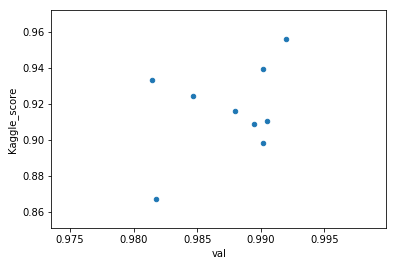

In [27]:
result.plot('val', 'Kaggle_score', kind= 'scatter')

Higher validation score correlated with higher Kaggle score. This means the validation set is pretty similar to the hold out set. 

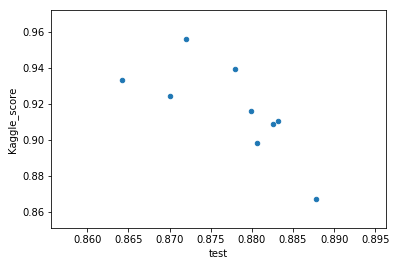

In [28]:
result.plot('test', 'Kaggle_score', kind= 'scatter')

Test set is not that similar to the hold out. Next, we rank model by the training score. 

In [30]:
result.sort_values('val', ascending=False)

,arch,val,test,Kaggle_score
0,dn201,0.991983,0.872047,0.95633
14,restnext101,0.990889,0.880577,NaN
3,resnet152,0.990525,0.883202,0.91081
5,resnext101,0.990160,0.877953,0.93941
7,resnet101,0.990160,0.880577,0.89830
12,wrn,0.989796,0.881890,NaN
8,vgg16,0.989431,0.882546,0.90888
10,vgg19,0.988703,0.876640,NaN
1,dn201,0.987974,0.879921,0.91595
11,resnext50,0.987974,0.878609,NaN


In [31]:
result.sort_values('test', ascending=False)

,arch,val,test,Kaggle_score
9,inception_4,0.981778,0.887795,0.86697
13,resnet18,0.985787,0.883858,NaN
3,resnet152,0.990525,0.883202,0.91081
8,vgg16,0.989431,0.882546,0.90888
12,wrn,0.989796,0.881890,NaN
7,resnet101,0.990160,0.880577,0.89830
14,restnext101,0.990889,0.880577,NaN
1,dn201,0.987974,0.879921,0.91595
11,resnext50,0.987974,0.878609,NaN
5,resnext101,0.990160,0.877953,0.93941


In summary, there seems to be a correlation between the training set and the hold out set. Therefore, I can use the validation accuracy for choosing a model. The best architecture is dn201, which gives accuracy of 95.63% on Kaggle hold out set (150 position on the leaderboard). The other two models, resnext101, and resnet101, seem to perform well for both train and test sets. 

To improve the prediction accuracy, I plan to train the model using another set of satellite images. Use the pretrained weight on this dataset.  